In [1]:
# Import local mnist data
import gzip
import numpy as np

def import_img(num, path):
    f = gzip.open(path, 'r')

    image_size = 784

    f.read(16)
    buf = f.read(image_size * num)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float64)
    data = data.reshape(num, image_size)
    f.close()
    print(data.shape)
    return data

def import_lbl(num, path):
    f = gzip.open(path, 'r')

    image_size = 784
    f.read(8)
    
    labels = []
    for i in range(num):
        buf = f.read(1)
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
        labels.extend(label)
    f.close()
    return np.array(labels)
    
train_img = import_img(11000, 'train-images-idx3-ubyte.gz')
train_lbl = import_lbl(11000, 'train-labels-idx1-ubyte.gz')
test_img = import_img(1000, 't10k-images-idx3-ubyte.gz')
test_lbl = import_lbl(1000, 't10k-labels-idx1-ubyte.gz')

(11000, 784)
(1000, 784)


In [2]:
def one_hot_encoder(data):
    encoded = np.array([[1 if label == i else 0 for i in range(10)] for label in data])
    return encoded

In [3]:
import numpy as np
from copy import deepcopy

train_img = train_img[:10000]
train_lbl = train_lbl[:10000]
vali_img = train_img[-1000:]
vali_lbl = train_lbl[-1000:]
test_img = test_img[:1000]
test_lbl = test_lbl[:1000]
test_lbl_not_encoded = deepcopy(test_lbl) # save for cofusion matrix

# Normalization (0~255) to (0~1)
train_img, vali_img, test_img = train_img / 255.0, vali_img / 255.0, test_img / 255.0

# One hot encoding
train_lbl = one_hot_encoder(train_lbl)
vali_lbl = one_hot_encoder(vali_lbl)
test_lbl = one_hot_encoder(test_lbl)

print("trainging image :",  train_img.shape)
print("trainging label :",  train_lbl.shape)
print("validation image :",  vali_img.shape)
print("validation label :",  vali_lbl.shape)
print("testing image : ", test_img.shape)
print("testing label : ", test_lbl.shape)

trainging image : (10000, 784)
trainging label : (10000, 10)
validation image : (1000, 784)
validation label : (1000, 10)
testing image :  (1000, 784)
testing label :  (1000, 10)


In [4]:
def data_loader(x_data, y_data, batch_size = 64):
    assert (x_data.shape[0] == y_data.shape[0])

    batch_len, remainder = divmod(x_data.shape[0], batch_size)

    remainder = 1 if remainder != 0 else 0
    for i in range(batch_len + remainder):
        start = i*batch_size
        if i == batch_len + remainder - 1:
            yield x_data[start:], y_data[start:]
        else:
            yield x_data[start:start + batch_size], y_data[start:start + batch_size]

In [5]:
import random as rd
import numpy as np

class Linear:
    alpha = 0.01
    learning_rate = 0.0001
    def __init__(self, in_features, out_features, activation_function):
        self.in_f = in_features
        self.out_f = out_features
            
        #set activation function on this layer
        if activation_function == 'relu':
            self.activation_function = {'forward': self.relu, 'backward':self.relu_backward}
        elif activation_function == 'lrelu':
            self.activation_function = {'forward': self.lrelu, 'backward':self.lrelu_backward}
        elif activation_function == 'softmax':
            self.activation_function = {'forward': self.softmax, 'backward':self.softmax_backward}
        else:
            raise Exception("Invalid activation function")
            
        self.refresh()
        self.initialize()
        
    def refresh(self):
        #forward
        self.linear_input = 0
        self.activation_input = 0 # == linear_output
        self.activation_output = 0
        
        #backward
        self.dActivation = 0
        self.dLinear = 0
        
    def initialize(self):
        #random initialization
        self.weight = np.random.randn(self.out_f, self.in_f)
        self.bias = np.zeros((1, self.out_f))
        
    def __call__(self, batch): 
        return self.forward(batch)
        
  # FORWARD PROPAGATION
    def forward(self, batch):
        # linear forward + activation forward
        assert(batch.shape[1] == self.in_f)
       
        self.length = batch.shape[0]
        self.linear_input = batch
        
        self.activation_input = self.linear()        
        self.activation_output = self.activation_function['forward']()

        return self.activation_output
        
    def linear(self):
        without_bias = np.dot(self.linear_input, self.weight.T)
        return np.add(without_bias, self.bias)
    
    def relu(self):
        return np.maximum(0, self.activation_input)

    def lrelu(self):
        return np.maximum(Linear.alpha*self.activation_input, self.activation_input)
    
    def softmax(self):
        result = np.zeros(self.activation_input.shape)
        for i, line in enumerate(self.activation_input):
            new_line = line / self.in_f # prevent exp overflow
            exps = np.exp(new_line)
            result[i] = exps / np.sum(exps)
        return result
        
  # BACKWARD PROPAGATION
    def backward(self, gradient):
        # activation backward + linear backward
        self.dActivation = np.multiply(self.activation_function['backward'](), gradient)
        self.dLinear = self.linear_backward() #tuple
        return self.dLinear[0]
    
    def linear_backward(self):
        dL_input = np.dot(self.dActivation, self.weight)
        dL_weight = np.dot(self.dActivation.T, self.linear_input)
        dL_bias = np.sum(self.dActivation, axis = 0, keepdims = True)
        
        assert(dL_input.shape == self.linear_input.shape)
        assert(dL_weight.shape == self.weight.shape)
        assert(dL_bias.shape == self.bias.shape)
        
        return dL_input, dL_weight, dL_bias
    
    def relu_backward(self):
        return np.where(self.activation_input > 0, 1, 0)
        
    def lrelu_backward(self):
        return np.where(self.activation_input > Linear.alpha*self.activation_input, 1, Linear.alpha)
    
    def softmax_backward(self):
        return np.multiply(self.activation_output, (1 - self.activation_output))
    
  # UPDATE WEIGHT AND BIAS
    def update(self):
        self.weight -= Linear.learning_rate * self.dLinear[1]
        self.bias -= Linear.learning_rate * self.dLinear[2]


In [6]:
class CELoss:
    def __init__(self):
        self.label = 0
        self.prob = 0
        self.loss = 0
        self.dLoss = 0
        
    def __call__(self, label, prob):
        assert (label.shape == prob.shape)
        assert (label.shape[1] == 10)
        self.set_data(label, prob)
        return self.forward()
        
    def set_data(self, label, prob):
        # substitute for log calculation
        prob[prob == 0] = 1e-200
        prob[prob == 1] = 9.9e-1 

        self.label = label
        self.prob = prob
#         print('in label, prob',self.label, self.prob)
        
    # caculate loss(= cost)
    def forward(self):
        result = np.zeros((self.prob.shape[0], 1))
        for i, (prob, label) in enumerate(zip(self.prob, self.label)):
            result[i] = - np.sum(label*np.log(prob) + (1 - label)*np.log(1 - prob))
        self.loss = result
        return self.loss

    def backward(self):
        self.dLoss = -np.divide(self.label, self.prob) + np.divide(1-self.label, 1-self.prob)
        assert(self.dLoss.shape == self.prob.shape)
        return self.dLoss

In [7]:
class Model:
    def __init__(self, nodes, activations):
        assert(len(nodes) == len(activations) + 1)
        
        self.layers = []
        self.loss_object = CELoss()
        self.batches = 0
        
        # set layers for the model
        for i in range(len(activations)):
            layer = Linear(nodes[i], nodes[i + 1], activations[i])
            self.layers.append(layer)
    
    # learn 'epochs' times / need tra and vali parameter for loss history
    def learn(self, batches, epochs = 10, tra = None, vali = None):
        loss_history = [] # each element is tuple(t_loss ,v_loss)
        if tra and vali:
            loss_history.append(self.cal_loss(tra, vali))
        for epoch in range(epochs):
#             print('-----------------------')
#             print(epoch + 1, 'epoch')
            self.batches = batches
            self.learn_batches()
            if tra and vali: # monitor train / validation-loss
                loss_history.append(self.cal_loss(tra, vali))
        return loss_history

       
    def cal_loss(self, tra, vali):
        t_loss, __ = self.test(tra[0], tra[1]) # (img, lbl) 
        v_loss, _ = self.test(vali[0], vali[1]) # (img, lbl) 
        return t_loss, v_loss
    
    # learn whole data once
    def learn_batches(self):
        for img, lbl in self.batches:
            data = self.forward(img)
                    
            grad = self.loss_back(lbl, data)
            
            self.backward(grad)
            self.update()
            self.refresh()
            
    def predict(self, x):
        prob = self.compute_prob(x)
        return self.prob_to_label(prob)
            
    def compute_prob(self, x):
        # return probability array
        return self.forward(x)
    
    def prob_to_label(self, prob):
        # prob to label in prob
        return np.argmax(prob, axis = 1)
    
    def average_loss(self, matrix):
        loss = np.sum(matrix / matrix.size)
        return loss
            
    # return average loss and accuracy
    def test(self, x, y):
        correct = wrong = 0
        self.prob = self.compute_prob(x)
        loss = self.loss_object(y, self.prob) # loss forward
        loss = self.average_loss(loss)
        
        self.predicted = self.prob_to_label(self.prob)
        for label, pred in zip(y, self.predicted):
            if (label[pred] == 1):
                correct += 1
            else:
                wrong += 1
        return loss, correct / (correct+wrong)

    def forward(self, data):
        for layer in self.layers:
            data = layer(data)
        return data
    
    def backward(self, data):
        for layer in reversed(self.layers):
            data = layer.backward(data)
            
    def update(self):
        for layer in self.layers:
            layer.update()

    def refresh(self):
        for layer in self.layers:
            layer.refresh()
            
    def loss_back(self, label, prob):
        self.loss_object.set_data(label, prob)
        return self.loss_object.backward()

In [8]:
from time import time

models = {}
loss_history = {}
activations = ['relu', 'lrelu']

In [9]:
# Learn and Test (Including Validation)
for act in activations:
    print(f'<{act} Model>')
    nodes = [784, 182, 42, 10]
    activation = [act, act, 'softmax']
    model = Model(nodes, activation)
    models[act] = model

    epochs = 50
    batch_size = 64
    batches = data_loader(train_img, train_lbl, batch_size)
    batches = list(batches)
    

    start_time = time()
    # average loss history in every epoch
    loss_history[act] = model.learn(batches, epochs, tra = (train_img, train_lbl), vali = (vali_img, vali_lbl))
    loss, accuracy = model.test(test_img, test_lbl)
    end_time = time()

    print('Average loss:', loss)
    print('Accuracy:', accuracy)

    elapsed = end_time - start_time 
    print('Running time:', elapsed, 'seconds')

<relu Model>
Average loss: 0.5963725254592896
Accuracy: 0.91
Running time: 53.7198486328125 seconds
<lrelu Model>
Average loss: 0.7127624465408007
Accuracy: 0.896
Running time: 71.0429139137268 seconds


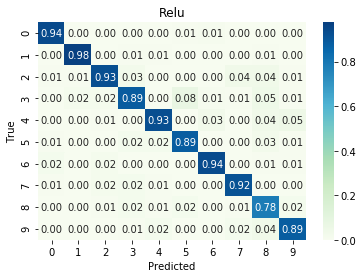

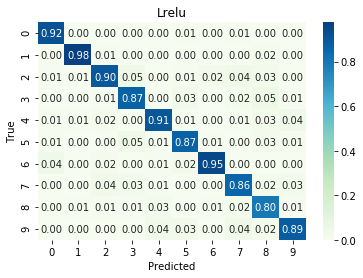

In [10]:
# Plot confusion matrix for test
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

for act in activations:
    true_l = test_lbl_not_encoded
    pred_l = models[act].predicted
    conf_mat = confusion_matrix(true_l, pred_l)
    conf_mat = conf_mat/ np.sum(conf_mat, axis = 0)
    
    sn.heatmap(conf_mat, annot=True, fmt='.2f', cmap='GnBu')
    plt.title(act.capitalize())
    plt.xlabel('Predicted')
    plt.ylabel('True')
#     plt.savefig(act+'_cf.png')
    plt.show()

[array([1.        , 0.99999992, 1.        , 1.        , 1.        ,
       1.        , 0.99999999, 0.99999993, 0.99999975, 0.99998824]), array([1.        , 0.9999999 , 1.        , 0.99999948, 0.99999991,
       1.        , 0.99999998, 0.99999991, 0.99999902, 0.99998446]), array([0.99999999, 0.99999989, 0.99999999, 0.999999  , 0.99999975,
       0.99999999, 0.99999997, 0.9999999 , 0.99999877, 0.99997805])]


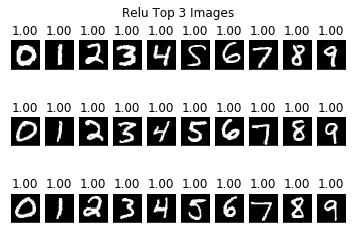

[array([1.        , 0.99999863, 1.        , 0.99999998, 0.99999969,
       0.99999995, 1.        , 0.99999995, 0.99999733, 0.99995571]), array([1.        , 0.99999552, 1.        , 0.99999997, 0.9999995 ,
       0.99999828, 0.99999989, 0.99999994, 0.99999666, 0.99992428]), array([1.        , 0.99999412, 1.        , 0.99999996, 0.9999995 ,
       0.99999823, 0.99999988, 0.99999993, 0.99999627, 0.99991447])]


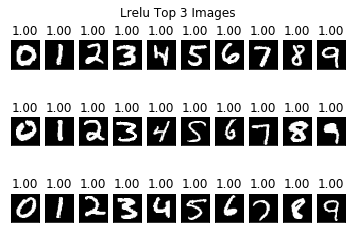

In [11]:
# Top 3 scored images for test
for act in activations:
    prob = models[act].prob.copy() # matrix
    res_pos = [] # position : 0~999
    res_prob = [] # probability : 0~1
    for i in range(3):
        res_pos.append(np.argmax(prob, axis = 0))
        res_prob.append(np.max(prob, axis = 0))
        enum = list(enumerate(res_pos[i]))
        for label, pos in enum:
            # label : 0~9, pos : 0~999
            prob[pos, label] = 0
        
    fig = plt.figure(1)
    plt.title(act.capitalize() + " Top 3 Images")
    plt.axis('off')
    box_index = 1
    for pos, probs in zip(res_pos, res_prob):
        images = test_img[pos].reshape(10, 784)
        for image, prob in zip(images, probs):
            ax = fig.add_subplot(3, 10, box_index)
            pixels = image.reshape((28, 28))
            plt.imshow(pixels, cmap='gray')
            subt = '{:.2f}'.format(prob)
            ax.title.set_text(subt)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    print(res_prob)
#     plt.savefig(act+'_top3.png')
    plt.show()

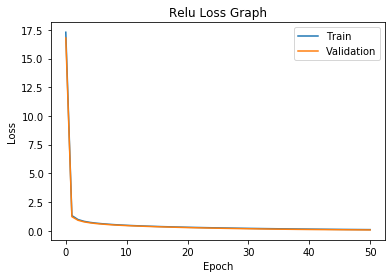

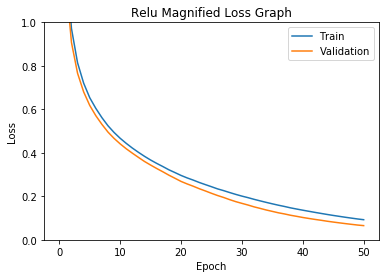

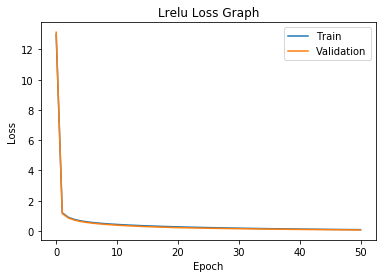

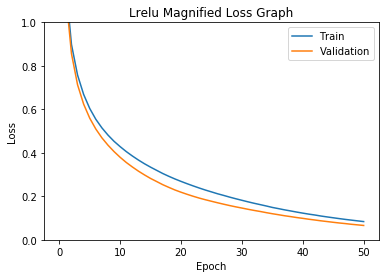

In [12]:
# Plot loss graph for train and validation
for act in activations:
    history = np.array(loss_history[act]).T
    assert(history.shape[0] == (2))
    t_loss = history[0]
    v_loss = history[1]
    name = act.capitalize()
    
    x = range(0, epochs + 1)
    plt.plot(x, t_loss)
    plt.plot(x, v_loss)
    plt.title(name+' Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
#     plt.savefig(act+'_loss.png')
    plt.show()

    plt.plot(x, t_loss)
    plt.plot(x, v_loss)
    plt.title(name+' Magnified Loss Graph')
    plt.ylim(0, 1)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
#     plt.savefig(act+'_mloss.png')
    plt.show()